# Preparation

## Import packages

In [91]:
import anndata
import json
import src.df_accessors
from src.ryp import r, to_r, to_py
from pathlib import Path
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
r(
"""
library(dplyr)
library(tidyr)
library(msigdbr)
library(fgsea)
library(stringr)
"""
)

## Load data

In [27]:
adata = anndata.read_h5ad("results/preprocessed_adata_three.h5ad")
glm_results = adata.uns["simple"]

In [28]:
with open("data/mappings/prop_names.json") as f:
    prop_names = json.load(f)

## Define functions

In [29]:
def union_lists(lists):
    if isinstance(lists, dict):
        lists = lists.values()
    return set.union(*map(set, lists))

def get_sig_introns_dict(glm_results, predictor_list, VGIC_only):
    '''
    Given a list of predictors, return a dictionary of significant introns for each predictor
    '''
    return {subclass_name: glm_results.glm.rank_introns_by_n_sig_corr(subclass_name, VGIC_only, True).index.to_list() for subclass_name in predictor_list}

In [66]:
def run_fgsea(path, predictor):
    glm_results = dd.read_csv([path for path in Path(path).iterdir()], include_path_column = True)\
        .assign(ll_ratio = lambda x: 2*(x["ll"] - x["ll_null"]))\
        .pivot_table(index = "event_name", columns = "path", values = "ll_ratio").compute()
    glm_results.rename(columns = {path: Path(path).stem for path in glm_results.columns}, inplace = True)    
    glm_results["gene_name"] = glm_results.reset_index()["event_name"].str.split("_", expand = True).iloc[:, 0].values
    ranked_gene_list = glm_results[["gene_name", predictor]]\
        .groupby("gene_name").first()\
        .sort_values(predictor, ascending = False)\
        [predictor]\
        .to_dict()
    to_r(ranked_gene_list, "ranked_gene_list")
    
    r(
    """
    ranked_gene_list <- unlist(ranked_gene_list)
    fgsea_res <- fgsea(pathways = term_list, stats = ranked_gene_list, minSize = 15, maxSize = 500) %>% 
        left_join(distinct(db, gs_subcat, gs_exact_source, gs_name, gs_description), by = c("pathway" = "gs_exact_source"))
    """
    )
    return to_py("fgsea_res", format="pandas")[["pathway", "padj", "pval", "NES", "size", "gs_name", "gs_subcat", "gs_description"]]

# Start here

## ORA

In [30]:
VGIC_only = False

ephys_union = glm_results.glm.rank_introns_by_n_sig_corr("ephys_prop", VGIC_only=VGIC_only, sig_only=True).index.to_list()
subclass_union = glm_results.glm.rank_introns_by_n_sig_corr("subclass", VGIC_only=VGIC_only, sig_only=True).index.to_list()
universe = glm_results.glm.rank_introns_by_n_sig_corr("all", VGIC_only=VGIC_only, sig_only=True).index.to_list()

ephys_only = [intron.split("_")[0] for intron in list(set(ephys_union) - set(subclass_union))]

In [31]:
r(
''' 
db <- msigdbr(species = "Mus musculus", category = "C5", subcategory = NULL)
conv <- unique(db[, c("gene_symbol", "gs_exact_source")])
term_list <- split(x = conv$gene_symbol, f = conv$gs_exact_source)
'''
)

In [34]:
to_r(ephys_only, "ephys_only")
to_r(universe, "universe")
# to_r(adata.var.gene_name.unique().tolist(), "universe")

In [35]:
r(
"""
fora(pathways = term_list, genes = ephys_only, universe = universe, minSize = 15, maxSize = 500) %>% 
    left_join(distinct(db, gs_subcat, gs_exact_source, gs_name, gs_description), by = c("pathway" = "gs_exact_source"))
"""
)


Empty data.table (0 rows and 9 cols): pathway,pval,padj,overlap,size,overlapGenes...


## GSEA

In [67]:
r(
"""
db <- msigdbr(species = "Mus musculus", category = "C5")
conv <- unique(db[, c("gene_symbol", "gs_exact_source")])
term_list <- split(x = conv$gene_symbol, f = conv$gs_exact_source)
"""
)

## Multiple

In [68]:
path = "proc/scquint/three/multiple"

In [69]:
glm_results = dd.read_csv([path for path in Path(path).iterdir()], include_path_column = True)\
    .assign(ll_ratio = lambda x: 2*(x["ll"] - x["ll_null"]))\
    .pivot_table(index = "event_name", columns = "path", values = "ll_ratio").compute()
glm_results.rename(columns = {path: Path(path).stem for path in glm_results.columns}, inplace = True)

In [70]:
res_multiple = run_fgsea(path, "rheo_upstroke_downstroke_ratio")

Text(0.5, 1.0, 'No covarying for subclass')

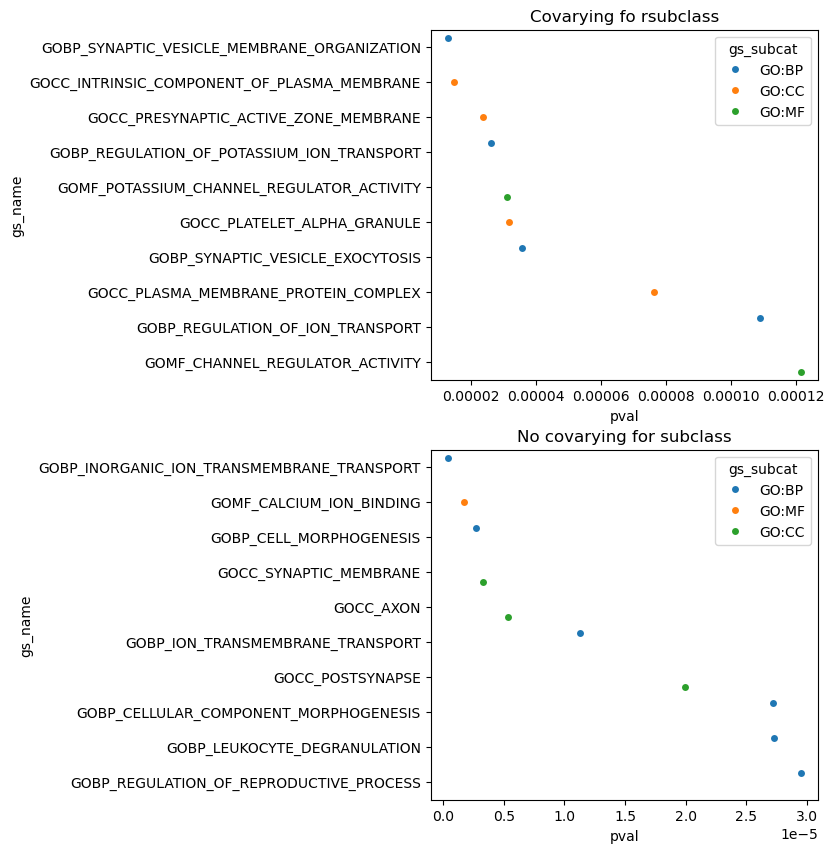

In [100]:
fig, axs = plt.subplots(2, 1, figsize = (5, 10))
res_multiple\
    .query("gs_subcat != 'HPO'")\
    .sort_values("pval")\
    .iloc[np.arange(0, 10), :]\
    .pipe(sns.stripplot, x = "pval", y = "gs_name", hue = "gs_subcat", dodge = True, ax = axs[0])
axs[0].set_title("Covarying fo rsubclass")

res_simple\
    .query("gs_subcat != 'HPO'")\
    .sort_values("pval")\
    .iloc[np.arange(0, 10), :]\
    .pipe(sns.stripplot, x = "pval", y = "gs_name", hue = "gs_subcat", dodge = True, ax = axs[1])
axs[1].set_title("No covarying for subclass")

# Simple

In [72]:
path = "proc/scquint/three/simple"

In [73]:
glm_results = dd.read_csv([path for path in Path(path).iterdir()], include_path_column = True)\
    .assign(ll_ratio = lambda x: 2*(x["ll"] - x["ll_null"]))\
    .pivot_table(index = "event_name", columns = "path", values = "ll_ratio").compute()
glm_results.rename(columns = {path: Path(path).stem for path in glm_results.columns}, inplace = True)

In [74]:
res_simple  = run_fgsea(path, "rheo_upstroke_downstroke_ratio")

<Axes: xlabel='pval', ylabel='gs_name'>

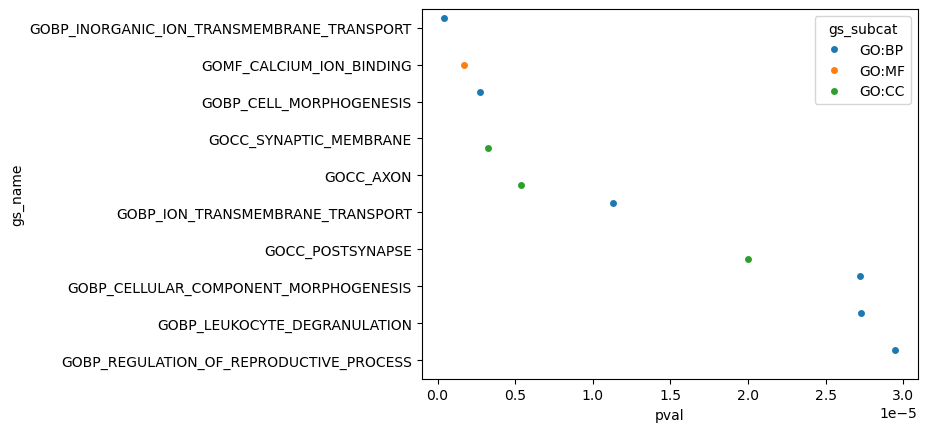